# Example usage

The Viam SDK can be used in three ways:
1. As a client to connect to a (remote or local) robot
2. Integrate custom resources to a robot
3. As a client to connect to app.viam.com to upload and retrieve data

## Connect as a client

To connect to a robot as a client, you should instantiate an instance of a `RobotClient`

In [1]:
# Please excuse the boilerplate
%autoawait asyncio
import warnings

warnings.filterwarnings("ignore")

In [2]:
from viam import logging
from viam.robot.client import RobotClient
from viam.rpc.dial import DialOptions


async def connect() -> RobotClient:
    options = RobotClient.Options(dial_options=DialOptions(insecure=True, disable_webrtc=True), log_level=logging.FATAL)
    return await RobotClient.at_address("localhost:9091", options)

You can also create a `RobotClient` by providing an existing connection

In [3]:
from viam import logging
from viam.robot.client import RobotClient
from viam.rpc.dial import DialOptions, dial


async def connect_with_channel() -> RobotClient:
    async with await dial("localhost:9091", DialOptions(insecure=True, disable_webrtc=True)) as channel:
        return await RobotClient.with_channel(channel, RobotClient.Options(refresh_interval=10, log_level=logging.FATAL))


robot = await connect_with_channel()
print(robot.resource_names)
await robot.close()

[namespace: "rdk"
type: "component"
subtype: "arm"
name: "arm0"
, namespace: "rdk"
type: "component"
subtype: "audio_input"
name: "audio_input0"
, namespace: "rdk"
type: "component"
subtype: "base"
name: "base0"
, namespace: "rdk"
type: "component"
subtype: "board"
name: "board"
, namespace: "rdk"
type: "component"
subtype: "camera"
name: "camera0"
, namespace: "rdk"
type: "component"
subtype: "gantry"
name: "gantry0"
, namespace: "rdk"
type: "component"
subtype: "gripper"
name: "gripper0"
, namespace: "rdk"
type: "component"
subtype: "motor"
name: "motor0"
, namespace: "rdk"
type: "component"
subtype: "movement_sensor"
name: "movement_sensor0"
, namespace: "rdk"
type: "component"
subtype: "pose_tracker"
name: "pose_tracker0"
, namespace: "rdk"
type: "component"
subtype: "sensor"
name: "sensor0"
, namespace: "rdk"
type: "component"
subtype: "servo"
name: "servo0"
]


Once you have a connected `RobotClient`, you can then obtain the robot's components by their name

In [5]:
from viam.components.camera import Camera
from viam.media.video import CameraMimeType
from viam.media.utils.pil import viam_to_pil_image

robot = await connect_with_channel()
camera = Camera.from_robot(robot, "camera0")
image = await camera.get_image(CameraMimeType.JPEG)
pil = viam_to_pil_image(image)
pil.save("foo.png")

# Don't forget to close the robot when you're done!
await robot.close()

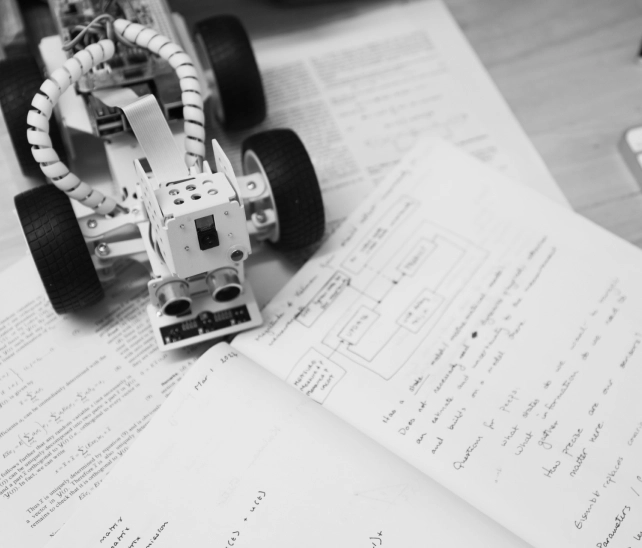

In [7]:
display(image)

You can also use the `RobotClient` to make service calls to the connected robot.

In [ ]:
from viam.services.vision import VisionClient


async def vision():
    robot = await connect_with_channel()
    vision = VisionClient.from_robot(robot)
    detections = await vision.get_detections_from_camera("camera_1", "detector_1")

At the end, don't forget to close the connection

In [5]:
async def cleanup():
    await robot.close()

## Create custom modules
Make a modular resource from an existing resource API. In this document, we will be going over subclassing existing resource APIs. To learn more about creating a new resource API, see the [Viam docs](https://docs.viam.com/extend/modular-resources/#code-your-module), and [complex module example](https://github.com/viamrobotics/viam-python-sdk/tree/main/examples/complex_module).

For a fully fleshed-out example of a Python module that uses Github CI to upload to the Viam Registry, take a look at [python-example-module](https://github.com/viam-labs/python-example-module). For an example that uses Docker to manage dependencies, take a look at [python-container-module](https://github.com/viamrobotics/python-container-module). For a list of example modules in different Viam SDKs, take a look [here](https://github.com/viamrobotics/upload-module/#example-repos).

The code below resembles the [simple module example](https://github.com/viamrobotics/viam-python-sdk/tree/main/examples/simple_module), so look there for the final, completed modular resource.

The steps required in creating a modular resource and connecting it to a robot are:
1. **Subclass a resource and implement desired functions.** This will be your custom resource model.
    - For functions that you do not wish to implement, you must at least define them by putting `pass` or `raise NotImplementedError()` in the function.
2. **Register a new model.** This will register the new modular resource model into the `Registry`.
3. **Start the module.** Create and start the new module.
4. **Make the module executable.** This allows `viam-server` to access and execute the module.
5. **Configure a modular resource.** Use the new module and instantiate a new resource to a robot!

Knowing this, let's implement a custom resource.
    
### 1. Subclass a resource
The SDK provides a wide array of resource APIs to customize. You can browse through the API Reference to see the available resources. Subclass a resource and implement the required functions. You may leave the other methods unimplemented by putting `pass` or `raise NotImplementedError()` in the function.

This example uses a `Sensor` as an example.

Create a sensor that returns the Wi-Fi signal of a Pi. Start by creating a directory on the Pi named `wifi-sensor`, then create a directory inside the `wifi-sensor` directory named `src`. Then, inside the `src` directory, create a new file named `wifi_sensor_module.py`.
Copy the code below into your `wifi_sensor_module.py` file:

```python
# wifi-sensor/src/wifi_sensor_module.py
import asyncio
from typing import Any, Dict, Mapping, Optional

from viam.components.sensor import Sensor
from viam.utils import SensorReading


class MySensor(Sensor):
    # Subclass the Viam Sensor component and implement the required functions
    async def get_readings(self, extra: Optional[Dict[str, Any]] = None, **kwargs) -> Mapping[str, SensorReading]:
        with open("/proc/net/wireless") as wifi_stats:
            content = wifi_stats.readlines()
        wifi_signal = [x for x in content[2].split(" ") if x != ""]
        return {"link": wifi_signal[2], "level": wifi_signal[3], "noise": wifi_signal[4]}
    
    async def get_geometries(self, *, extra: Optional[Dict[str, Any]] = None, timeout: Optional[float] = None) -> List[Geometry]:
        raise NotImplementedError

    async def close(self):
        # This is a completely optional function to include. This will be called when the resource is removed from the config or the module
        # is shutting down.
        self.logger.info(f"{self.name} is closed.")

# Anything below this line is optional and will be replaced later, but may come in handy for debugging and testing.
# To use, call `python wifi_sensor_module.py` in the command line while in the `src` directory.
async def main():
    wifi=MySensor(name="wifi")
    signal = await wifi.get_readings()
    print(signal)

if __name__ == '__main__':
    asyncio.run(main())
```

You can view more component implementations in the [examples](https://github.com/viamrobotics/python-sdk/blob/main/examples/server/v1/components.py).

### 2. Register the new modular resource
Now that we've created the modular resource model, we must register it to the registry.

Define a [`Model`](https://docs.viam.com/appendix/glossary/#term-model) name and a creator function in the resource. A creator function is a function that can create a resource given a config and map of dependencies.

To define a creator function and `Model` in `wifi_sensor_module.py`, import `ComponentConfig`, `ResourceName`, `ResourceBase`, `Model`, and `ModelFamily` from the relative viam packages. Please note that the import packages also have to be changed to include `Mapping` and `ClassVar` from `typing` and `Self` from `typing_extensions`. The changes can be seen in the example below.

In your `wifi_sensor_module.py`, define a new `MODEL` variable in your `MySensor` class, shown below. Then add a `new()` function that will act as our creator function. We get the name from the config and return the resource. We can also assign class variables based on what the config has. 

```python
# wifi-sensor/src/wifi_sensor_module.py
import asyncio
from typing import Any, ClassVar, Dict, Mapping, Optional
from typing_extensions import Self

from viam.proto.app.robot import ComponentConfig
from viam.proto.common import ResourceName
from viam.resource.base import ResourceBase
from viam.resource.types import Model, ModelFamily

class MySensor(Sensor):
    # Subclass the Viam Sensor component and implement the required functions
    MODEL: ClassVar[Model] = Model(ModelFamily("viam","sensor"), "linux-wifi")

    @classmethod
    def new(cls, config: ComponentConfig, dependencies: Mapping[ResourceName, ResourceBase]) -> Self:
        sensor = cls(config.name)
        return sensor
```

After the resource model has a defined model and creator function, the resource model must be registered to the `Registry`. This can be done using [`register_resource_creator()`](https://python.viam.dev/autoapi/viam/resource/registry/index.html#viam.resource.registry.Registry.register_resource_creator) and passing a [`ResourceCreatorRegistration`](https://python.viam.dev/autoapi/viam/resource/registry/index.html#viam.resource.registry.ResourceCreatorRegistration) object with the creator function as a parameter.

In the main function of `wifi_sensor_module.py`, call `Registry.register_resource_creator()` with the subtype of the resource that was subclassed, the model name, and a `ResourceCreatorRegistration` object with the creator function defined in the modular resource. In a more complex module, it makes sense to call the function in an `__init__.py` file in the same folder as the new resource model. See [here](https://github.com/viamrobotics/viam-python-sdk/tree/main/examples/complex_module/src/arm/__init__.py) for an example.

```python
# wifi-sensor/src/wifi_sensor_module.py
from viam.resource.registry import Registry, ResourceCreatorRegistration

async def main():
    Registry.register_resource_creator(Sensor.SUBTYPE, MySensor.MODEL, ResourceCreatorRegistration(MySensor.new))
```

Click [here](https://github.com/viamrobotics/viam-python-sdk/blob/main/docs/examples/module_step2.py) to see the file with its new `MODEL` variable, creator function, and `main()` function.

#### Optional Validator and Reconfiguration Functions
Modules also have support for validator and reconfiguration functions.

Custom validation can be done by specifying a validate function. Validate functions can raise errors that will be returned to the parent through gRPC. Validate functions return two sequences of strings: the first represents the implicit required dependencies and the second represents the optional dependencies. If there are none for either, return an empty sequence `[]` (if there are no required dependencies and no optional dependencies, return `[], []`) .

For example, let's say `MySensor` had a `multiplier` argument that is used to multiply the returned readings in `get_readings()`. The validation function can check if a multiplier attribute was provided and prevent erroneous resource start ups.

Reconfiguration specifies what values can change based on a new configuration. To allow this, add a `reconfigure()` function to the `MySensor` class. A good pattern is to call `reconfigure()` within `new()`, since initialization and reconfiguration are usually very similar.

```python
# ADD `Sequence` and `Tuple` FROM `typing`.
from typing import Sequence, Tuple

from viam.utils import SensorReading

class MySensor(Sensor):
    # ADD A VALIDATOR FUNCTION 
    @classmethod
    def validate_config(cls, config: ComponentConfig) -> Tuple[Sequence[str], Sequence[str]]:
        if "multiplier" in config.attributes.fields:
            if not config.attributes.fields["multiplier"].HasField("number_value"):
                raise Exception("Multiplier must be a float.")
            multiplier = config.attributes.fields["multiplier"].number_value
            if multiplier == 0:
                raise Exception("Multiplier cannot be 0.")
        # RETURN EMPTY SEQUENCES (no required or optional dependencies necessary)
        return [], []

    @classmethod
    def new(cls, config: ComponentConfig, dependencies: Mapping[ResourceName, ResourceBase]) -> Self:
        sensor = cls(config.name)
        # CALL RECONFIGURE TO INITIALIZE THE RESOURCE
        sensor.reconfigure(config, dependencies)        
        return sensor

    def reconfigure(self, config: ComponentConfig, dependencies: Mapping[ResourceName, ResourceBase]):
        if "multiplier" in config.attributes.fields:
            multiplier = config.attributes.fields["multiplier"].number_value
        else:
            multiplier = 1.0
        self.multiplier = multiplier

    async def get_readings(self, extra: Optional[Dict[str, Any]] = None, **kwargs) -> Mapping[str, SensorReading]:
        with open("/proc/net/wireless") as wifi_stats:
            content = wifi_stats.readlines()
        result = [x for x in content[2].split(" ") if x != ""]
        
        # MULTIPLY THE READINGS WITH MULTIPLIER
        wifi_signal = []
        for i in range(2:5):
            wifi_signal.append(int(result[i]) * self.multiplier)
        return {"link": wifi_signal[0], "level": wifi_signal[1], "noise": wifi_signal[2]}
```

If a validator function is added, it must also be called when registering the resource. The `ResourceCreatorRegistration` should now also have the validator function passed in as the second parameter. 

```python
        async def main():
            Registry.register_resource_creator(Sensor.SUBTYPE, MySensor.MODEL, ResourceCreatorRegistration(MySensor.new, MySensor.validate_config))
```
Click [here](https://github.com/viamrobotics/viam-python-sdk/blob/main/docs/examples/module_step2_optional.py) to see the new `wifi_sensor_module.py` with the optional validator and reconfiguration functions.

### 3. Start the module
The module now has to be created and started. In the `wifi_sensor_module.py` file, update the main function to the following. If there is a validator function in the class, don't forget to add the function to the `ResourceCreatorRegistration` object. In a more complex module, it makes sense to create an entirely new entrypoint file. See [here](https://github.com/viamrobotics/viam-python-sdk/tree/main/examples/complex_module/src/main.py) for an example.

```python
# wifi-sensor/src/wifi_sensor_module.py
from viam.module.module import Module


async def main():
    """
    This function creates and starts a new module, after adding all desired resource model.
    Resource creators must be registered to the resource registry before the module adds the resource model.
    """
    Registry.register_resource_creator(Sensor.SUBTYPE, MySensor.MODEL, ResourceCreatorRegistration(MySensor.new))

    module = Module.from_args()
    module.add_model_from_registry(Sensor.SUBTYPE, MySensor.MODEL)
    await module.start()


if __name__ == "__main__":
    asyncio.run(main())
```

To see `wifi_sensor_module.py` with all of the changes, click [here](https://github.com/viamrobotics/viam-python-sdk/blob/main/docs/examples/module_step3.py).

### 4. Make the module executable
To add the module to your robot, you must provide it as an [executable file](https://docs.viam.com/extend/modular-resources/#make-your-module-executable) that [`viam-server` can access](https://docs.viam.com/extend/modular-resources/#make-sure-viam-server-can-access-your-executable).

Dependencies for the module (including Viam SDK) have to be installed. In the `wifi-sensor` directory, create a new file called `requirements.txt` that has all your dependencies. For this example, add `viam-sdk` in `requirements.txt`.

```
# add a version if viam should be pinned to a specific version
viam-sdk
```

One option with the Python SDK is to create a new shell script (`.sh`) that runs your module, which can also be used to install the dependencies. For example, in the `wifi-sensor` directory, add an `run.sh` file:

```sh
#!/bin/sh
cd `dirname $0`

# Create a virtual environment to run our code
VENV_NAME="venv"
PYTHON="$VENV_NAME/bin/python"
ENV_ERROR="This module requires Python >=3.8, pip, and virtualenv to be installed."

if ! python3 -m venv $VENV_NAME >/dev/null 2>&1; then
    echo "Failed to create virtualenv."
    if command -v apt-get >/dev/null; then
        echo "Detected Debian/Ubuntu, attempting to install python3-venv automatically."
        SUDO="sudo"
        if ! command -v $SUDO >/dev/null; then
            SUDO=""
        fi
		if ! apt info python3-venv >/dev/null 2>&1; then
			echo "Package info not found, trying apt update"
			$SUDO apt -qq update >/dev/null
		fi
        $SUDO apt install -qqy python3-venv >/dev/null 2>&1
        if ! python3 -m venv $VENV_NAME >/dev/null 2>&1; then
            echo $ENV_ERROR >&2
            exit 1
        fi
    else
        echo $ENV_ERROR >&2
        exit 1
    fi
fi

# remove -U if viam-sdk should not be upgraded whenever possible
# -qq suppresses extraneous output from pip
echo "Virtualenv found/created. Installing/upgrading Python packages..."
if ! $PYTHON -m pip install -r requirements.txt -Uqq; then
    exit 1
fi

# Be sure to use `exec` so that termination signals reach the python process,
# or handle forwarding termination signals manually
echo "Starting module..."
exec $PYTHON src/wifi-sensor.py $@
```

**Please note that a more complex module should be run as a Python module, meaning that the file extension `.py` has to be omitted. See [here](https://github.com/viamrobotics/viam-python-sdk/tree/main/examples/complex_module/run.sh) for an example.** 

To make this shell script executable, run this in the Terminal:

```sudo chmod +x <FILEPATH>/<FILENAME>```

`<FILENAME>` would be `run.sh`.



### 5. Configure a modular resource
**NOTE:** *If you are adding your module to the registry, follow [these instructions](https://docs.viam.com/extend/modular-resources/configure/) instead. Otherwise, continue with these instructions, which will show you how to configure the module locally.*

[Configure your new module](https://docs.viam.com/extend/modular-resources/#configure-your-module) on your robot by navigating to the **Config** tab of the machine's page, then click on the **Modules** subtab. Add the name of your module and the executable path. For our example, the path would be `<path-on-your-filesystem>/linux-wifi/run.sh`.

Once you have configured a module as part of your robot configuration, [configure your modular resource](https://docs.viam.com/extend/modular-resources/#configure-your-modular-resource) made available by that module by adding new components or services configured with your modular resources' new type or model. To instantiate a new resource from your module, specify the `type`, `model`, and `name` of your modular resource. The aforementioned `type`, `model`, and `name` should be the same as those in the `MODEL` class attribute defined in your [component class](#register-the-custom-component). This is a JSON example:

```json
{
  "components": [
    {
      "model": "viam:sensor:linux-wifi",
      "attributes": {},
      "depends_on": [],
      "name": "my-sensor",
      "type": "sensor"
    }
  ],
  "modules": [
    {
      "executable_path": "<path-on-your-filesystem>/linux-wifi/run.sh",
      "name": "wifi_sensor"
    }
  ]
}
```

Note the nomenclature of the above `model` field, `viam:sensor:linux-wifi`. Models are uniquely namespaced as colon-delimited-triplets in the form `namespace:family:name`, and are named according to the Viam API that your model implements. A model with the `viam` namespace is always Viam-provided. Read more about making custom namespaces [here](https://docs.viam.com/registry/create/#name-your-new-resource-model).

Viam also provides many built-in models that implement API capabilities, each using `rdk` as the `namespace`, and `builtin` as the `family`:
- The `rdk:builtin:gpio` model of the `rdk:component:motor` API provides RDK support for [GPIO-controlled DC motors](https://docs.viam.com/components/motor/gpio/).
- The `rdk:builtin:DMC4000` model of the same `rdk:component:motor` API provides RDK support for the [DMC4000](https://docs.viam.com/components/motor/dmc4000/) motor.

### Custom Modular Arm Example
The following is an example of how to implement a custom modular arm. For further instructions, read the detailed `Sensor` example above. Our custom Arm will be extremely simple. Please note that the minimum set of endpoints you need to implement for an arm are `GetKinematics`, `GetJointPositions`, and `MoveToJointPositions`.

This arm example contains a minimal kinematics model. For a full model, take a look [here](https://github.com/viamrobotics/viam-python-sdk/blob/main/examples/complex_module/src/arm/my_arm_kinematics.json).

Subclassing the `Arm` component and implementing the required functions:
```python
# modular-arm/src/my_modular_arm.py
import asyncio
import os
from typing import Any, ClassVar, Dict, Mapping, Optional, Tuple
from typing_extensions import Self

from viam.components.arm import Arm, JointPositions, KinematicsFileFormat, Pose
from viam.module.module import Module
from viam.operations import run_with_operation
from viam.proto.app.robot import ComponentConfig
from viam.proto.common import ResourceName
from viam.resource.base import ResourceBase
from viam.resource.registry import Registry, ResourceCreatorRegistration
from viam.resource.types import Model, ModelFamily


class MyModularArm(Arm):
    # Subclass the Viam Arm component and implement the required functions
    MODEL: ClassVar[Model] = Model(ModelFamily("viam", "arm"), "my-arm")

    def __init__(self, name: str):
        # Starting joint positions
        self.joint_positions = JointPositions(values=[0, 0, 0, 0, 0, 0])


        # Minimal working kinematics
        self.kinematics = json.dumps(
            {
                "name": "MyArm",
                "links": [{"id": "base", "parent": "world", "translation": {"x": 0, "y": 0, "z": 0}}],
                "joints": [
                    {"id": "waist", "type": "revolute", "parent": "base", "axis": {"x": 0, "y": 0, "z": 1}, "max": 359, "min": -359}
                ],
            }
        ).encode("utf-8")
        super().__init__(name)

    @classmethod
    def new(cls, config: ComponentConfig, dependencies: Mapping[ResourceName, ResourceBase]) -> Self:
        arm = cls(config.name)
        return arm

    async def get_end_position(self, extra: Optional[Dict[str, Any]] = None, **kwargs) -> Pose:
        raise NotImplementedError()

    async def move_to_position(self, pose: Pose, extra: Optional[Dict[str, Any]] = None, **kwargs):
        raise NotImplementedError()

    async def get_joint_positions(self, extra: Optional[Dict[str, Any]] = None, **kwargs) -> JointPositions:
        return self.joint_positions

    @run_with_operation
    async def move_to_joint_positions(self, positions: JointPositions, extra: Optional[Dict[str, Any]] = None, **kwargs):
        operation = self.get_operation(kwargs)

        self.is_stopped = False

        # Simulate the length of time it takes for the arm to move to its new joint position
        for x in range(10):
            await asyncio.sleep(1)

            # Check if the operation is cancelled and, if it is, stop the arm's motion
            if await operation.is_cancelled():
                await self.stop()
                break
        
        self.joint_positions = positions
        self.is_stopped = True

    async def stop(self, extra: Optional[Dict[str, Any]] = None, **kwargs):
        self.is_stopped = True

    async def is_moving(self) -> bool:
        return not self.is_stopped

    async def get_kinematics(self, extra: Optional[Dict[str, Any]] = None, **kwargs) -> Tuple[KinematicsFileFormat.ValueType, bytes]:
        return KinematicsFileFormat.KINEMATICS_FILE_FORMAT_SVA, self.kinematics

async def main():
    """This function creates and starts a new module, after adding all desired resource model.
    Resource creators must be registered to the resource registry before the module adds the resource model.
    """
    Registry.register_resource_creator(Arm.SUBTYPE, MyModularArm.MODEL, ResourceCreatorRegistration(MyModularArm.new))
    module = Module.from_args()
    module.add_model_from_registry(Arm.SUBTYPE, MyModularArm.MODEL)
    await module.start()


if __name__ == "__main__":
    asyncio.run(main())
```

Lastly, make the module executable and configure the module on your robot.

## Create custom remotes

**CAUTION** *[Modular resources](https://python.viam.dev/examples/example.html#create-custom-modules) are the preferred method of creating custom resource implementations for the Python SDK unless you are hosting viam-server on a non-Linux system or have another issue with compilation.*

While the main RDK is written in golang, you can create custom components in python and connect them to a robot as a [`remote` component](https://docs.viam.com/extend/custom-components-remotes/). This allows you to extend the functionality of a robot, or even create an entire robot exclusively in python.

To create a custom component and connect it to the RDK:
1. **Subclass a component and implement desired functions**. This will be your custom component.
    - For functions you do not wish to implement, you must at least define them by putting `pass` or `raiseNotImplementedError()` in the function.
1. **Create an `rpc.server.Server` instance and register the custom component**. This is the `RPC` server that enables communication with your custom component.
1. **Start the `Server` and register the running server as a remote**. Registering this `RPC` server as a remote allows the RDK to communicate with the server.


### 1. Subclass a component

The SDK provides a wide array of components to customize. You can browse through the API Reference to see all of them, but for now we'll use an `Arm` as an example. Our custom Arm will be extremely simple -- it will only save and return the positions provided to it.

Let's start by creating a directory called `my-python-robot`. Inside of that directory, create a file called `my_cool_arm.py`. The contents of `my_cool_arm.py` should be as follows:

In [1]:
from pygments import highlight
from pygments.lexers import PythonLexer
from pygments.formatters import HtmlFormatter
import IPython

with open("my_cool_arm.py") as f:
    code = f.read()

formatter = HtmlFormatter()
IPython.display.HTML(
    '<style type="text/css">{}</style>{}'.format(formatter.get_style_defs(".highlight"), highlight(code, PythonLexer(), formatter))
)

You can view more component implementations in the [examples](https://github.com/viamrobotics/python-sdk/blob/main/examples/server/v1/components.py).

This arm example contains a minimal kinematics model. For a full model, take a look [here](https://github.com/viamrobotics/viam-python-sdk/blob/main/examples/complex_module/src/arm/my_arm_kinematics.json).

### 2. Register the custom component

Now that we've created the custom component, we must register it so that it will be visible to any robots connecting to it. This is done by creating an `RPC` server and adding `MyCoolArm` as a connected component. This `RPC` server will receive gRPC requests from the Viam Server or any other connections and forward those requests to your custom component.

In the same `my-python-robot` directory, create a new file called `main.py`.

In [3]:
# my-python-robot/main.py

import asyncio
from viam.rpc.server import Server

from my_cool_arm import MyCoolArm


async def main():
    srv = Server([MyCoolArm("my-arm")])
    await srv.serve()


if __name__ == "__main__":
    try:
        asyncio.run(main())
    except:
        pass

/var/folders/vh/04mycgp163125hlq8k9bkl8w0000gn/T/ipykernel_50114/2037726754.py:15: RuntimeWarning: coroutine 'main' was never awaited
  pass


### 3. Start the Server and add it as a Remote

Now that we have a server that knows about our custom Arm component, we need to start the server so it can receive gRPC calls. Once it's started, we can then register this server as a remote.

```python3
# my-python-robot/main.py

async def main():
  ...
  await srv.serve()
```
**NB**: When you call `srv.serve()`, the default host and port is `localhost:9090`. This can be changed by passing in a `host` and/or `port` parameter to the `serve` function.

To use this custom server as part of a larger robot, you’ll want to add it as a `remote` in the config for your main part.
```json
[
    {
      "name": "my-cool-python-components", // The name of the remote, can be anything
      "insecure": true,                    // Whether this connection should use SSL
      "address": "localhost:9090"          // The location of the remote robot
    }
  ]
```

And to ensure that the python server starts up with the rest of the robot, you can add it as a process. 
```json
[
  {
    "id": "my-python-server-process",
    "log": true,
    "name": "python",
    "args": [
      "/home/pi/my-python-robot/main.py"
    ]
  }
]
```

**NB**: The `viam-server` starts as a root process, so you may need to switch users to run the python SDK server.
```json
[
  {
    "id": "0",
    "log": true,
    "name": "sudo",
    "args": [
      "-u",
      "pi",
      "python",
      "/home/pi/my-python-robot/main.py"
    ]
  }
]
```

## Convert a custom remote to a custom module
Modular resources are the preferred method of creating custom resource implementations for the Python SDK unless you are hosting viam-server on a non-Linux system or have another issue with compilation. Already existing custom remote resources can be converted to custom module resources.

This section will go over the steps it takes to convert a custom remote to a custom module.
`MySensor` is currently a custom remote component, written here:
```python
import asyncio
from typing import Any, Dict, List, Mapping, Optional

from viam.components.sensor import Geometry, Sensor
from viam.rpc.server import Server
from viam.utils import SensorReading


class MySensor(Sensor):
    async def get_readings(self, extra: Optional[Dict[str, Any]] = None, **kwargs) -> Mapping[str, SensorReading]:
        with open("/proc/net/wireless") as wifi_stats:
            content = wifi_stats.readlines()
        wifi_signal = [x for x in content[2].split(" ") if x != ""]
        return {"link": wifi_signal[2], "level": wifi_signal[3], "noise": wifi_signal[4]}

    async def get_geometries(self) -> List[Geometry]:
        raise NotImplementedError


async def main():
    srv = Server([MySensor("my-sensor")])
    await srv.serve()


if __name__ == "__main__":
    asyncio.run(main())
```

The two steps that are required to convert a custom remote resource to a custom module resource are as follows:
1. **Register the resource.** This will register a new modular resource model into the Registry.
2. **Make the module executable.** This allows viam-server to access and execute the module.

Add a [`Model`](https://docs.viam.com/extend/modular-resources/#models) name and a creator function in the resource by defining a new `MODEL` variable in the class. Then add a function that will act as the creator function. For more details on how to add these two, follow the pertaining steps in [Register the new modular resource](https://python.viam.dev/examples/example.html#register-the-new-modular-resource).

```python
# ADD THE NECESSARY IMPORTS TO DEFINE A MODEL NAME AND CREATOR FUNCTION.
from typing import ClassVar, Mapping
from typing_extensions import Self

from viam.proto.app.robot import ComponentConfig
from viam.proto.common import ResourceName
from viam.resource.base import ResourceBase
from viam.resource.types import Model, ModelFamily

class MySensor(Sensor):
    # ADD A MODEL NAME IN THE EXISTING RESOURCE CLASS.
    MODEL: ClassVar[Model] = Model(ModelFamily("viam-labs","sensor"), "test")

    # ADD A CREATOR FUNCTION IN THE EXISTING RESOURCE CLASS.
    @classmethod
    def new(cls, config: ComponentConfig, dependencies: Mapping[ResourceName, ResourceBase]) -> Self:
        resource = cls(config.name)
        return resource
```

In the resource's main function or `main.py` file, replace the content of `main()` with the content below:
```python
# ADD THE NECESSARY IMPORTS TO REGISTER THE NEW MODEL
from viam.module.module import Module
from viam.resource.registry import Registry, ResourceCreatorRegistration

# REPLACE THE MAIN FUNCTION/FILE SO THAT IT CALLS `register_resource_creator()` AND STARTS THE MODULE.
async def main():
    Registry.register_resource_creator(Sensor.SUBTYPE, MySensor.MODEL, ResourceCreatorRegistration(MySensor.new))

    module = Module.from_args()
    module.add_model_from_registry(Sensor.SUBTYPE, MySensor.MODEL)
    await module.start()
```

Follow the steps outlined in the section [Make the module executable](https://python.viam.dev/examples/example.html#make-the-module-executable) in the directory of the component.

The custom remote component is now a custom module component. To use the component in the web UI, follow the steps to [configure the new modular resource](https://python.viam.dev/examples/example.html#configure-a-modular-resource).

For easy visualization, the differences in the configuration JSONs and code are below.

| Custom remote | Custom module |
| :--- | :--- |
| <pre>{<br>    "remotes": [<br>      {<br>        "name": "my-sensor",<br>        "insecure": true,<br>        "address": "localhost:9090"<br>      }<br>    ],<br>    "processes": [<br>      {<br>        "id": "my-python-server-process",<br>        "log": true,<br>        "name": "python",<br>        "args": [<br>          "/home/my_sensor/my_sensor.py"<br>        ]<br>      }<br>    ]<br>  } </pre>| <pre>{<br>  "components": [<br>    {<br>      "depends_on": [],<br>      "model": "viam-labs:sensor:test",<br>      "name": "my-sensor",<br>      "type": "sensor",<br>      "attributes": {}<br>    }<br>  ],<br>  "modules": [<br>    {<br>      "executable_path": "/home/my_sensor/run.sh",<br>      "name": "testsensor",<br>      "type": "local"<br>    }<br>  ]<br>} </pre>|

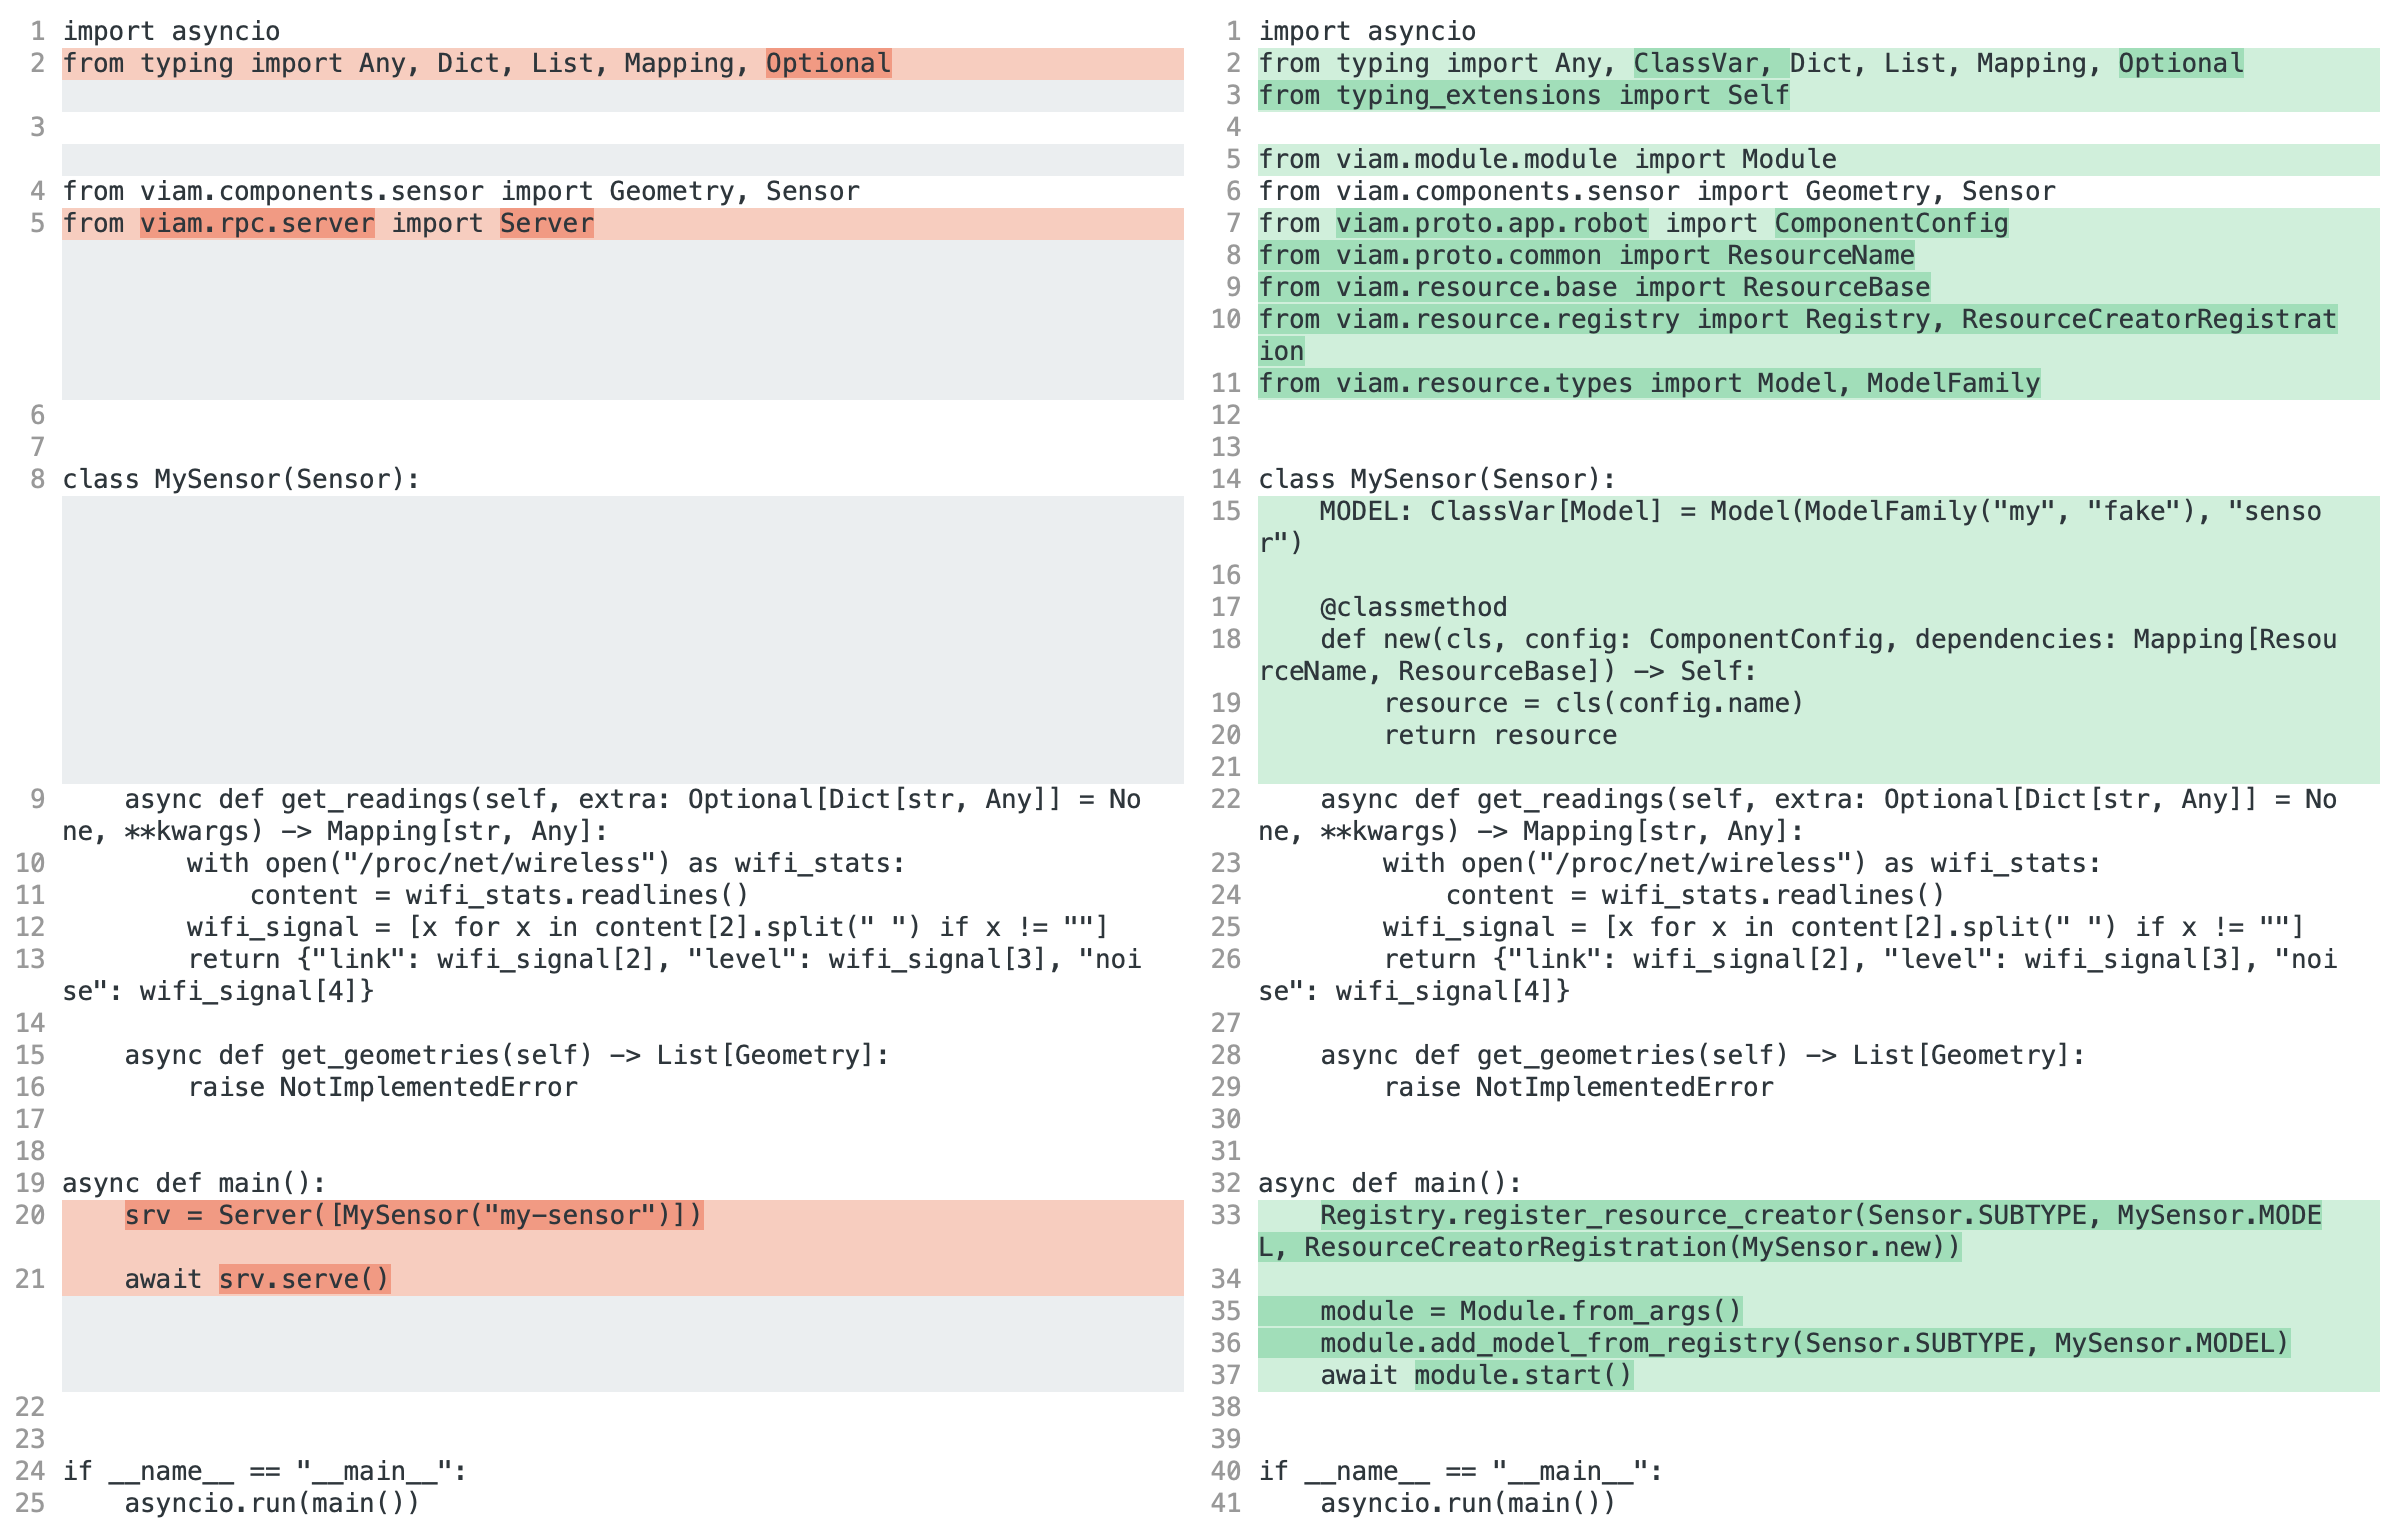

In [9]:
from IPython.core.display import display, Image

display(Image(filename="./codediff.png"))

## Operations

Operations are used by the RDK to keep track of running tasks, and provide a means to query their status and even cancel them. In order for a component to respond appropriately to any Operation requests, we must obtain and listen to the Operation in our method calls.

In order to take advantage of operations, you should wrap the component method with the `run_with_operation` decorator from the `viam.operations` package. Each component has a function, `get_operation(kwargs: Mapping[str, Any]) -> Operation`, that will return an Operation that will tell us if the operation is ever cancelled, allowing us to clean up any long running tasks, close connections, etc.

It is extremely important that we check the `Operation` status, as this not only prevents any unnecessary resource usage, but also allows us to respond to urgent cancellation requests and stop components' motion.

## Connect as a client to app

To connect to app as a client and make calls to the data API, you should create an instance of a `ViamClient` and retrieve its `DataClient` member.

In [1]:
from viam.rpc.dial import DialOptions, Credentials
from viam.app.viam_client import ViamClient


async def connect() -> ViamClient:
    dial_options = DialOptions.with_api_key(api_key="<API_KEY>", api_key_id="<API_KEY_ID>")
    return await ViamClient.create_from_dial_options(dial_options)

Once you have a connected `ViamClient`, you can then obtain a `DataClient` as a property.

In [2]:
# Hidden.
from typing_extensions import Self

from grpclib.client import Channel

from viam.app.data_client import DataClient
from viam.app.app_client import AppClient
from viam.rpc.dial import _dial_direct


class MockViamClient:
    @classmethod
    async def create_viam_client(cls) -> Self:
        self = cls()
        self._channel = await _dial_direct(address="localhost:9092", options=DialOptions(insecure=True))
        self.data_client = DataClient(channel=self._channel, metadata={})
        self.app_client = AppClient(channel=self._channel, metadata={})
        return self

    _channel: Channel
    data_client: DataClient
    app_client: AppClient

    def close(self):
        self._channel.close()


viam_client = await MockViamClient.create_viam_client()

In [3]:
data_client = viam_client.data_client

This `DataClient` can be used to make method calls that retrieve data from app.

In [4]:
from datetime import datetime
from viam.utils import create_filter

left_motor_filter = create_filter(
    component_name="left_motor", start_time=datetime(2023, 6, 5, 11), end_time=datetime(2023, 6, 5, 13, 30), tags=["speed_test_run"]
)

data = await data_client.tabular_data_by_filter(filter=left_motor_filter)
for tab in data:
    print(tab)

{'IsPowered': False, 'PowerPct': 0.0}
method_name: "IsPowered"
Time requested: 2022-01-01 01:01:01
Time received: 2022-12-31 23:59:59

{'IsPowered': False, 'PowerPct': 0.0}
location_id: "loc-id"
Time requested: 2023-01-02 00:00:00
Time received: 2023-03-04 00:00:00

{'Position': 0.0}
Time requested: 2023-05-06 00:00:00
Time received: 2023-07-08 00:00:00



You can also use your `DataClient` to upload data to app.

In [5]:
time_requested_1 = datetime(2023, 6, 5, 11)
time_received_1 = datetime(2023, 6, 5, 11, 0, 3)

await data_client.tabular_data_capture_upload(
    part_id="<ID>",  # Unique ID of the relevant robot part.
    component_type="rdk:component:motor",
    component_name="left_motor",
    method_name="IsPowered",
    method_parameters=None,
    tags=["tag_1", "tag_2"],
    data_request_times=[(time_requested_1, time_received_1)],
    tabular_data=[{"PowerPCT": 0, "IsPowered": False}],
)

`ViamClient` objects also house an `AppClient`, which can be used to retrieve information about your organization in App or make certain changes to it. The `AppClient` can be obtained in a manner similar to the `DataClient`.

In [6]:
app_client = viam_client.app_client

With this `AppClient`, you can access information about entities within your organization. For example, you can list information about all robots under your organization.

In [7]:
my_organizations = await app_client.list_organizations()
MY_ORG_ID = my_organizations[0].id
my_locations = await app_client.list_locations(org_id=MY_ORG_ID)
robots = []

for location in my_locations:
    more_robots = await app_client.list_robots(location_id=location.id)
    robots += more_robots

for robot in robots:
    print(robot.name)

robot-0
robot-1
robot-2
robot-3


You can also create new robots/robot parts or make updates to robots/robot parts that already already exist, or even delete them!

In [8]:
# Create a new robot named "new_rover".
NEW_ROBOT_ID = await app_client.new_robot(name="new_rover", location_id=my_locations[0].id)

# Change the new robot's name to "rover" and assign it a new parent location.
updated_robot = await app_client.update_robot(robot_id=NEW_ROBOT_ID, name="rover", location_id="<LOCATION_ID")

# Delete the new robot.
await app_client.delete_robot(robot_id=NEW_ROBOT_ID)

Certain types returned by `AppClient` methods (namely, `RobotPart`, `LogEntry`, `Fragment`, and `RobotPartHistoryEntry` objects) are wrapped in mirror classes that convert proto data into a friendlier, more readable format. Each of these mirrors still allows access to the initial proto type returned by the response as a property.

In [9]:
logs = await app_client.get_robot_part_logs(robot_part_id="<ID>", num_log_entries=1)
assert logs[0].caller is not None
for item in logs[0].caller.items():
    print(f"{item[0]}: {item[1]}")

print(f"\n*****PROTO*****\n")
print(logs[0].proto.caller)

Function: go.viam.com/rdk/robot/impl.(*resourceManager).updateResources
Line: 922.0
Defined: True
File: /__w/rdk/rdk/robot/impl/resource_manager.go

*****PROTO*****

fields {
  key: "Line"
  value {
    number_value: 922
  }
}
fields {
  key: "Function"
  value {
    string_value: "go.viam.com/rdk/robot/impl.(*resourceManager).updateResources"
  }
}
fields {
  key: "File"
  value {
    string_value: "/__w/rdk/rdk/robot/impl/resource_manager.go"
  }
}
fields {
  key: "Defined"
  value {
    bool_value: true
  }
}



At the end, you may close the connection.

In [10]:
viam_client.close()